In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import math
from scipy.stats import norm
sns.set_theme()


interest rates are from here https://fred.stlouisfed.org/series/FEDFUNDS

In [2]:
r = pd.read_csv("data/r.csv")
r['observation_date'] = pd.to_datetime(r['observation_date'])
r = r.rename(columns={'observation_date': "Date"})

sp500 = pd.read_csv("data/sp500.csv")
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.head()

,Date,Close/Last,Open,High,Low
0,2025-05-09,5659.91,5679.65,5691.69,5644.15
1,2025-05-08,5663.94,5663.60,5720.10,5635.38
2,2025-05-07,5631.28,5614.18,5654.73,5578.64
3,2025-05-06,5606.91,5605.87,5649.58,5586.04
4,2025-05-05,5650.38,5655.32,5683.38,5634.48


In [3]:
sp500 = pd.merge(sp500, r, on='Date', how='left')
sp500['FEDFUNDS'] = sp500['FEDFUNDS'].ffill()


In [4]:
sp500['log_return'] = np.log(sp500['Close/Last'] / sp500['Close/Last'].shift(1))
sp500['vol'] = sp500['log_return'].rolling(window=21).std() * np.sqrt(252)
sp500.dropna(inplace = True)
sp500.head()

,Date,Close/Last,Open,High,Low,FEDFUNDS,log_return,vol
21,2025-04-09,5456.90,4965.28,5481.34,4948.43,4.03,0.035221,0.236406
22,2025-04-08,4982.77,5193.57,5267.47,4910.42,3.83,-0.090895,0.388498
23,2025-04-07,5062.25,4953.79,5246.57,4835.04,3.86,0.015825,0.395862
24,2025-04-04,5074.08,5292.14,5292.14,5069.90,3.86,0.002334,0.396692
25,2025-04-03,5396.52,5492.74,5499.53,5390.83,3.92,0.061609,0.457333


In [5]:
sp500 = sp500[sp500['Date'] < pd.Timestamp('2025-01-01')]
sp500.head()

,Date,Close/Last,Open,High,Low,FEDFUNDS,log_return,vol
88,2024-12-31,5881.63,5919.74,5929.74,5868.86,4.16,0.002226,0.140340
89,2024-12-30,5906.94,5920.67,5940.79,5869.16,4.17,0.004294,0.138238
90,2024-12-27,5970.84,6006.17,6006.17,5932.95,4.20,0.010760,0.142756
91,2024-12-26,6037.59,6024.97,6049.75,6007.37,4.23,0.011117,0.147494
92,2024-12-24,6040.04,5984.63,6040.10,5981.44,4.24,0.000406,0.146516


In [6]:
sp500.isna().sum()

Date          0
Close/Last    0
Open          0
High          0
Low           0
FEDFUNDS      0
log_return    0
vol           0
dtype: int64

Text(0.5, 1.0, 'S&P500 Daily Log Returns')

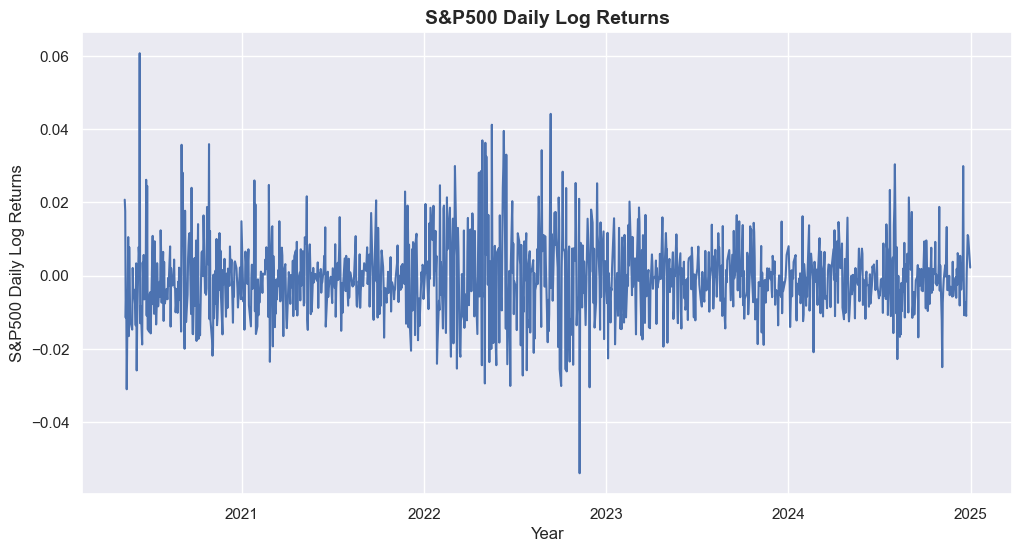

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(sp500['Date'], sp500['log_return'])
plt.xlabel("Year")
plt.ylabel("S&P500 Daily Log Returns")
plt.title('S&P500 Daily Log Returns', fontsize=14, weight='bold')

In [8]:
adfuller(sp500['log_return'])

'''
(-7.769083687372191,
 9.021738742924357e-12,
 21,
 1208,
 {'1%': -3.4357748759345768,
  '5%': -2.8639355566269677,
  '10%': -2.5680454348767596},
 -7548.924670261376)
'''

"\n(-7.769083687372191,\n 9.021738742924357e-12,\n 21,\n 1208,\n {'1%': -3.4357748759345768,\n  '5%': -2.8639355566269677,\n  '10%': -2.5680454348767596},\n -7548.924670261376)\n"

Sine p =   1.469715647824006e-12, we reject null and sp500 is stationary

Text(0.5, 1.0, 'S&P500 Vol')

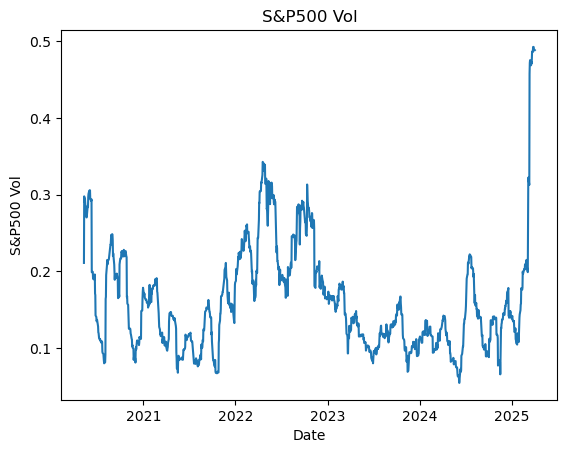

In [75]:
plt.plot(sp500['Date'], sp500['vol'])
plt.xlabel("Date")
plt.ylabel("S&P500 Vol")
plt.title("S&P500 Vol")

## Exploring a hypothetical binary call with K=5800, 1/1/2025 expiration

In [9]:
K = 5800  # Strike price
vol = 0.18  # Volatility
EXPIRATION_DATE = pd.Timestamp('2025-1-1')

def calculate_discounted_prob(row):
    S = row['Close/Last']  # Current price
    T = (EXPIRATION_DATE - row['Date']).days / 365.0  # Time to expiration in years
    r = row['FEDFUNDS'] / 100.0  # Convert fed funds rate to decimal
    
    # Calculate d1 and d2 using the provided formulas
    d1 = (math.log(S/K) + (r + 0.5 * vol**2)*T) / (vol * math.sqrt(T))
    d2 = d1 - (vol * math.sqrt(T))
    
    # Calculate N(d2)
    probability = norm.cdf(d2)
    
    # Calculate P * e^-rt
    discounted_prob = probability * math.exp(-r * T)
    
    return discounted_prob

In [10]:
sp500_2024 = sp500[sp500['Date'].dt.year == 2024].copy()
sp500_2024['discounted_probability'] = sp500_2024.apply(calculate_discounted_prob, axis=1)
sp500_2024['estimated_option_price'] = sp500_2024['discounted_probability'] * 100

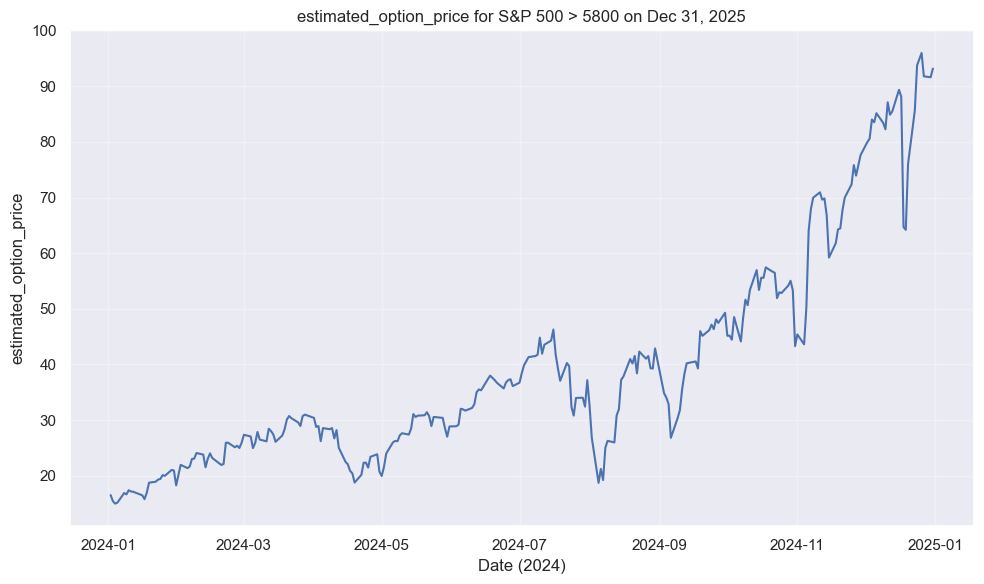

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(sp500_2024['Date'], sp500_2024['estimated_option_price'], 'b-')
plt.title(f'estimated_option_price for S&P 500 > {K} on Dec 31, 2025')
plt.xlabel('Date (2024)')
plt.ylabel('estimated_option_price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()